### Importing the dependencies

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split
import tensorflow as tf

print("Everything imported successfully")

Everything imported successfully


The `cp1252` encoding is a Windows-specific encoding that is often used for files that contain Western European characters.

In [2]:
# Loading the dataset
ISIS_df = pd.read_csv('Datasets/ISIS realted content/ISIS.csv', encoding='cp1252')
Twitter_df = pd.read_csv('Datasets/Normal Texts/Twitter_Data.csv')
Movie_df = pd.read_csv('Datasets/Normal Texts/Moive_data.csv')

### Exploratory data analysis and data processing

In [3]:
# Shape of datdaset
print("Shape of ISIS dataset : ",ISIS_df.shape)
print("Shape of Twitter dataset : ",Twitter_df.shape)
print("Shape of Movie dataset : ",Movie_df.shape)

Shape of ISIS dataset :  (2685, 8)
Shape of Twitter dataset :  (162980, 2)
Shape of Movie dataset :  (50000, 2)


Let's now see any 3 random rows of each of the dataframe to get an idea of what are the features present in each of the dataframe.

In [4]:
# Random 3 rows of dataframe
ISIS_df.sample(3)

,Magazine,Issue,Date,Type,Source,Quote,Purpose,Article Name
485,Dabiq,8.0,Mar-15,Qur'an,Muhammad 10,{Have they not traveled through the land and s...,Support,Erasing the Legacy of a Ruined Nation
1438,Dabiq,15.0,Jul-16,Bible,Matthew 15:24,"“He [Jesus] answered, ‘I was sent only to the ...",NaN,Break the Cross
1684,Rumiyah,5.0,Jan-17,Hadith Commentary,"Ibn Hajar al-Asqalani, ""Fath ul-Bari""","Nasihah for His Book is learning it, teaching ...",NaN,Religion is Nasihah Being Sincere


In [5]:
Twitter_df.sample(3)

,clean_text,category
74361,when modi announced beforehand and gives the s...,1.0
132176,this unemployment will decrease when people wi...,1.0
51165,great achievement narendra modi says india sho...,1.0


In [6]:
Movie_df.sample(3)

,review,sentiment
991,I dunno sometimes...you try and try and try to...,negative
6528,"This film is a knockout, Fires on the plain re...",positive
2873,Daddy's girls Florence Lawrence and Dorothy We...,negative


Now since we have got the basic understanding what are the feaures presenet in our datasets, our next step would be to remove unnecessary features from the dataframes and combine all the dataframes to make 1 big dataframe containing 2 features (Initally) Text and label.

In [7]:
# Dropping unnecessary features from ISIS related text dataset
ISIS_df.drop(['Purpose','Magazine','Issue','Date','Type'],axis=1,inplace=True)
Twitter_df.drop(['category'],axis=1,inplace=True)
Movie_df.drop(['sentiment'],axis=1,inplace=True)

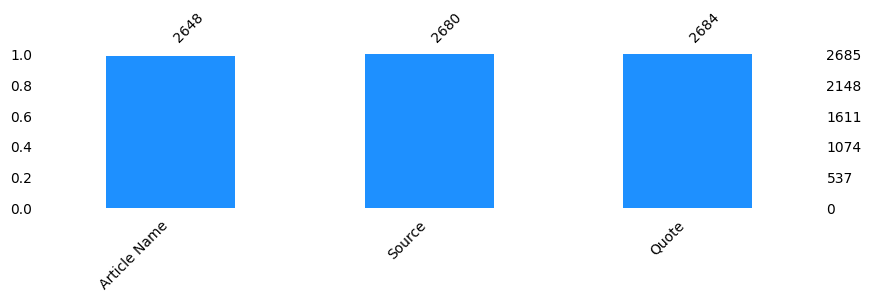

In [8]:
# Let's check if there are any null values
msno.bar(ISIS_df, figsize=(10,2), color="dodgerblue", sort="ascending", fontsize=10)
plt.show()

In [9]:
print("Movie dataframe missing values :",Movie_df.isnull().sum())
print("Twitter dataframe missing values :",Twitter_df.isnull().sum())

Movie dataframe missing values : review    0
dtype: int64
Twitter dataframe missing values : clean_text    4
dtype: int64


In [10]:
# Dropping missing values
Movie_df.dropna(inplace=True)
Twitter_df.dropna(inplace=True)
ISIS_df.dropna(inplace=True)

In [11]:
def combine_features(row):
  return ' '.join([row['Source'], row['Quote'], row['Article Name']])

ISIS_df['text'] = ISIS_df.apply(combine_features, axis=1)
ISIS_df.drop(['Source','Quote','Article Name'],axis=1,inplace=True)

In [12]:
# Lets's rename features of Twitter and Movie dataframe to text and label 
new_col_name_movie = {'review': 'text'}
Movie_df.rename(columns=new_col_name_movie, inplace=True)

new_col_name_twitter = {'clean_text': 'text'}
Twitter_df.rename(columns=new_col_name_twitter, inplace=True)

ISIS_df['label'] = 1
Movie_df['label'] = 0
Twitter_df['label'] = 0

In [13]:
# Let's select random 1350 rows from both movie and twitter dataframe
Movie_df = Movie_df.sample(1350)
Twitter_df = Twitter_df.sample(1350)

# Let's finally combine the dataframes 
df = pd.concat([ISIS_df,Movie_df,Twitter_df],axis=0)
df.reset_index(inplace=True,drop=True)

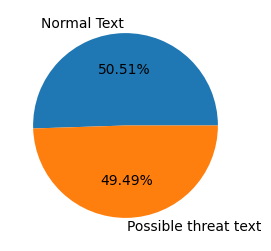

In [15]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.pie(x=df['label'].value_counts().values,labels=['Normal Text','Possible threat text'],autopct="%.2f%%")
plt.show()

## Tensorflow input pipeline
The tf.data API enables you to build complex input pipelines from simple, reusable pieces.The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

For loading the dataframe into tensorflow dataset we will be using the following operations
- Splitting the data into train,test and validation
- Create numpy arrays
- Convert numpy arrays to tensorflow tensors
- Load the tensors into tf dataset using `Dataset.from_tensor_slices`.

In [16]:
# training size, validation size, shuffle size
training_size = 0.8
validation_size = 0.1
shuffle_size = 10000

In [70]:
train_dataset = tf.data.Dataset.from_tensor_slices((df['text'], df['label']))

In [71]:
print(train_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [76]:
class Data_cleaning_Processing():

    def split_data(self, dataframe):
        """
        This method will take the dataframe as input and will return tf.datasets
        """
        train_data, test_val_data = train_test_split(df, train_size=0.8, shuffle=True, stratify=df['label'], random_state=1)
        val_data, test_data = train_test_split(test_val_data, train_size=0.5, shuffle=True, stratify=test_val_data['label'], random_state=1)

        # Converting dataframes to tf datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'], train_data['label']))
        test_dataset = tf.data.Dataset.from_tensor_slices((test_data['text'], test_data['label']))
        val_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'], val_data['label']))

        return (train_dataset, test_dataset, val_dataset)

In [77]:
dcp_obj = Data_cleaning_Processing()
train_dataset,test_dastaset,validation_dataset = dcp_obj.split_data(df)

In [78]:
validation_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Function for creating test, train and validation data batches
def train_test_val_batches(dataset, training_size, validation_size, shuffle_size):

    # Shuffling the dataset
    dataset = dataset.shuffle(shuffle_size, seed=12)

    # Creating batches for train, test, and validation
    train_dataset = dataset.take(int(len(dataset) * training_size)) #54 batches will be there in training dataset
    test_dataset = dataset.skip(int(len(dataset) * training_size)) # 14 in the test data
    validation_dataset = test_dataset.skip(int(len(test_dataset) * validation_size)) # 13 Batches in validation

    # Cache, Shuffle, and Prefetch the Datasets
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset, validation_dataset


# Calling the function
train_ds, test_ds, val_ds = train_test_val_batches(dataset, training_size, validation_size, shuffle_size)

In [ ]:
# Create the TensorFlow Dataset
dataset = tf.data.Dataset.from_dataframe(df)

### Data cleaning and processing using `TextVectorization` layer

Since we know that the machines i.e. (ML or DL Algorithms) can't understand text, so we need to process the raw text data into some form `numbers` which can be used by these algorithms for doing computation and understanding the pattern within the data. Now the thing to keep in mind is that other than simply giving a numerical representation to the textual data using some frequency based or neural network based technique such as `Word2Vec` or `Glove` we also need to clean the data which includes : punctuation removal, stop word removal, lowercasing, emoji-encoding, lemmatization/stemming or conversion of n-grams etc.

For doing all the above operations we will be using the `TextVectorization` layer provided by tensorflow. This layer can transforms a batch of strings (one example = one string) into either a list of token indices (one example = 1D tensor of integer token indices) or a dense representation (one example = 1D tensor of float values representing data about the example's tokens). 
